In [1]:
%pip install matplotlib
%pip install numpy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

def directory_setup():
    if not os.path.isdir("converted_files"):
        os.makedirs("converted_files")

    if not os.path.isdir("converted_files/libreoffice"):
        os.makedirs("converted_files/libreoffice")

    if not os.path.isdir("converted_files/pandoc"):
        os.makedirs("converted_files/pandoc")

    return

directory_setup()

In [2]:
import time

def compare_conversion_time(incoming_file):

    outgoing_file = f"{incoming_file.split('.')[0]}.pdf"

    # Pandoc

    if os.path.exists(f"converted_files/pandoc/{outgoing_file}"):
        os.remove(f"converted_files/pandoc/{outgoing_file}")

    t1 = time.time()
    _ = !docker run -d --rm --volume "$(pwd):/data" pandoc/latex:2.17 "{incoming_file}" --from docx --to pdf -o "./converted_files/pandoc/{outgoing_file}"
    t2 = time.time()

    duration_1 = t2 - t1

    # LibreOffice
    
    if os.path.exists(f"converted_files/libreoffice/{outgoing_file}"):
        os.remove(f"converted_files/libreoffice/{outgoing_file}")

    t1 = time.time()
    _ = !docker run -d --rm --volume "$(pwd):/data" instructure/libreoffice:6.3 bash -c "cd data && soffice --headless --convert-to pdf --outdir ./converted_files/libreoffice {incoming_file}"
    t2 = time.time()

    duration_2 = t2 - t1

    return {
        "p": duration_1,
        "l": duration_2
    }

In [3]:
output = !docker pull -q pandoc/latex:2.17

print(f"Successfully pulled {output[0]}")

Successfully pulled docker.io/pandoc/latex:2.17


In [4]:
output = !docker pull -q instructure/libreoffice:6.3

print(f"Successfully pulled {output[0]}")

Successfully pulled docker.io/instructure/libreoffice:6.3


In [5]:
import numpy as np

CONVERSION_ROUNDS = 3

conversion_files = ["file-sample_100kb.docx", "file-sample_500kb.docx", "file-sample_1MB.docx"]
conversion_files_results = []

print(f"Each file will be converted {CONVERSION_ROUNDS} times")

print("\n")

for conversion_file in conversion_files:
    print(f"Converting {conversion_file} to {conversion_file.split('.')[0]}.pdf")
    
    results_internal_p = []
    results_internal_l = []

    for i in range(CONVERSION_ROUNDS):
        results = compare_conversion_time(conversion_file)
        results_internal_p.append(results["p"])
        results_internal_l.append(results["l"])

    conversion_files_results.append({
        "conversion_file": conversion_file,
        "conversion_file_result": {
            "p": {
                "min": np.min(results_internal_p),
                "max": np.max(results_internal_p),
                "avg": np.mean(results_internal_p),
                "raw": results_internal_p
            },
            "l": {
                "min": np.min(results_internal_l),
                "max": np.max(results_internal_l),
                "avg": np.mean(results_internal_l),
                "raw": results_internal_l
            }
        }
    })

print("\n")
import json
for conversion_files_result in conversion_files_results:
    print(json.dumps(conversion_files_result, indent=3))

print("\n")

print("Converted files are available under './converted_files'")

Each file will be converted 3 times


Converting file-sample_100kb.docx to file-sample_100kb.pdf
Converting file-sample_500kb.docx to file-sample_500kb.pdf
Converting file-sample_1MB.docx to file-sample_1MB.pdf


{
   "conversion_file": "file-sample_100kb.docx",
   "conversion_file_result": {
      "p": {
         "min": 0.5524148941040039,
         "max": 0.9618189334869385,
         "avg": 0.7212676207224528,
         "raw": [
            0.9618189334869385,
            0.649569034576416,
            0.5524148941040039
         ]
      },
      "l": {
         "min": 0.3804497718811035,
         "max": 0.7676990032196045,
         "avg": 0.5816948413848877,
         "raw": [
            0.3804497718811035,
            0.7676990032196045,
            0.5969357490539551
         ]
      }
   }
}
{
   "conversion_file": "file-sample_500kb.docx",
   "conversion_file_result": {
      "p": {
         "min": 0.5902440547943115,
         "max": 3.735927104949951,
         "avg": 2.0650757153

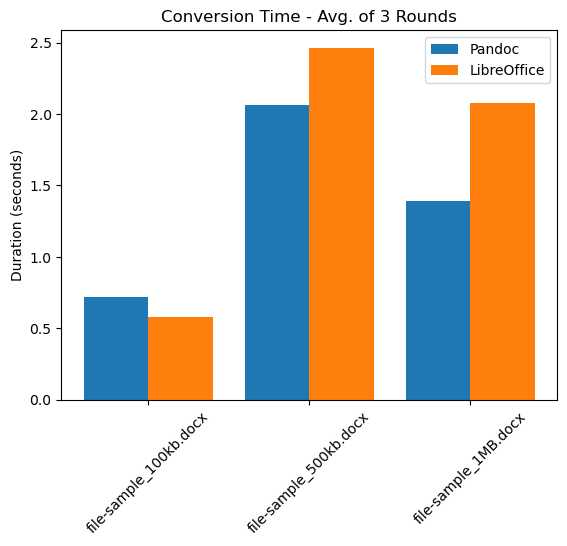

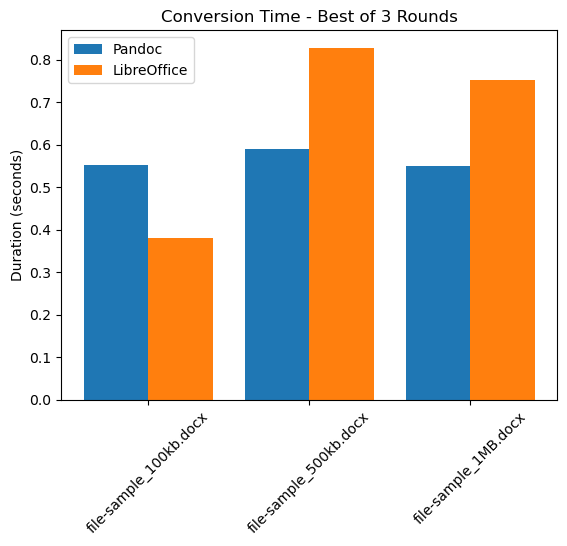

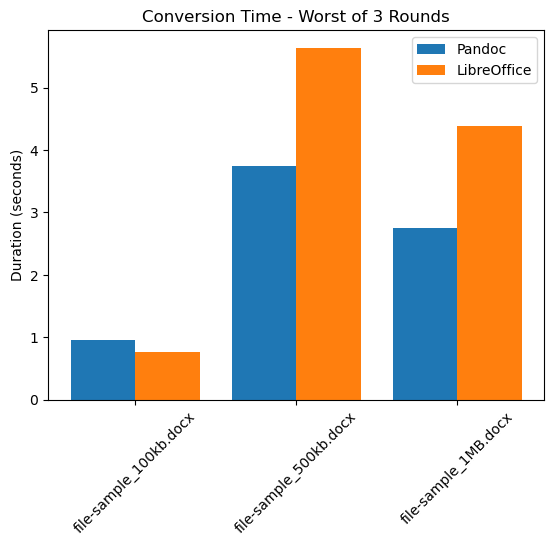

In [6]:
import matplotlib.pyplot as plt

# Compare the average of X rounds of conversions between Pandoc and LibreOffice

x1_avg = np.arange(len(conversion_files))

y1_avg = []
y2_avg = []

for conversion_files_result in conversion_files_results:
    y1_avg.append(conversion_files_result["conversion_file_result"]["p"]["avg"])
    y2_avg.append(conversion_files_result["conversion_file_result"]["l"]["avg"])
  
fig_avg, ax_avg = plt.subplots()

ax_avg.set_title(f"Conversion Time - Avg. of {CONVERSION_ROUNDS} Rounds")

x2_avg = [x + 0.40 for x in x1_avg]

ax_avg.bar(x1_avg, y1_avg, 0.40, label="Pandoc")
ax_avg.bar(x2_avg, y2_avg, 0.40, label="LibreOffice")

ax_avg.legend()
ax_avg.set_ylabel('Duration (seconds)')

ax_avg.set_xticks([r + 0.20 for r in range(len(conversion_files))])
ax_avg.set_xticklabels(conversion_files, rotation=45)

plt.show()

# Compare the best of X rounds of conversions between Pandoc and LibreOffice

x1_min = np.arange(len(conversion_files))

y1_min = []
y2_min = []

for conversion_files_result in conversion_files_results:
    y1_min.append(conversion_files_result["conversion_file_result"]["p"]["min"])
    y2_min.append(conversion_files_result["conversion_file_result"]["l"]["min"])
  
fig_min, ax_min = plt.subplots()

ax_min.set_title(f"Conversion Time - Best of {CONVERSION_ROUNDS} Rounds")

x2_min = [x + 0.40 for x in x1_min]

ax_min.bar(x1_min, y1_min, 0.40, label="Pandoc")
ax_min.bar(x2_min, y2_min, 0.40, label="LibreOffice")

ax_min.legend()
ax_min.set_ylabel('Duration (seconds)')

ax_min.set_xticks([r + 0.20 for r in range(len(conversion_files))])
ax_min.set_xticklabels(conversion_files, rotation=45)

plt.show()

# Compare the worst of X rounds of conversions between Pandoc and LibreOffice

x1_max = np.arange(len(conversion_files))

y1_max = []
y2_max = []

for conversion_files_result in conversion_files_results:
    y1_max.append(conversion_files_result["conversion_file_result"]["p"]["max"])
    y2_max.append(conversion_files_result["conversion_file_result"]["l"]["max"])
  
fig_max, ax_max = plt.subplots()

ax_max.set_title(f"Conversion Time - Worst of {CONVERSION_ROUNDS} Rounds")

x2_max = [x + 0.40 for x in x1_max]

ax_max.bar(x1_max, y1_max, 0.40, label="Pandoc")
ax_max.bar(x2_max, y2_max, 0.40, label="LibreOffice")

ax_max.legend()
ax_max.set_ylabel('Duration (seconds)')

ax_max.set_xticks([r + 0.20 for r in range(len(conversion_files))])
ax_max.set_xticklabels(conversion_files, rotation=45)

plt.show()

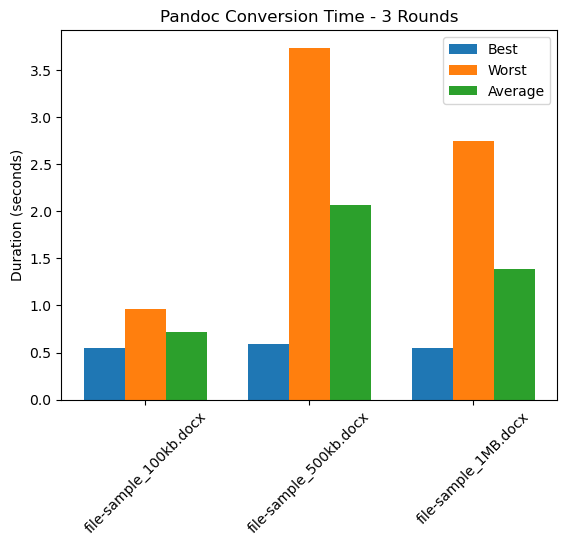

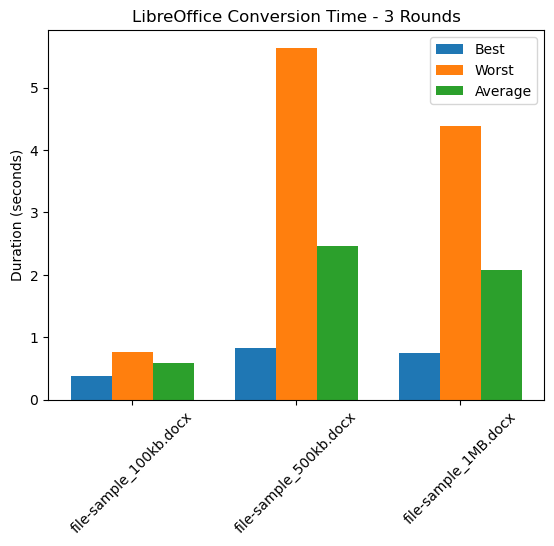

In [7]:
# Compare best, worst and average conversion time for each file using Pandoc

x1_p = np.arange(len(conversion_files))

y1_p = []
y2_p = []
y3_p = []

for conversion_files_result in conversion_files_results:
    y1_p.append(conversion_files_result["conversion_file_result"]["p"]["min"])
    y2_p.append(conversion_files_result["conversion_file_result"]["p"]["max"])
    y3_p.append(conversion_files_result["conversion_file_result"]["p"]["avg"])
  
fig_p, ax_p = plt.subplots()

ax_p.set_title(f"Pandoc Conversion Time - {CONVERSION_ROUNDS} Rounds")

x2_p = [x + 0.25 for x in x1_p]
x3_p = [x + 0.25 for x in x2_p]

ax_p.bar(x1_p, y1_p, 0.25, label="Best")
ax_p.bar(x2_p, y2_p, 0.25, label="Worst")
ax_p.bar(x3_p, y3_p, 0.25, label="Average")

ax_p.legend()
ax_p.set_ylabel('Duration (seconds)')

ax_p.set_xticks([r + 0.25 for r in range(len(conversion_files))])
ax_p.set_xticklabels(conversion_files, rotation=45)

plt.show()

# Compare best, worst and average conversion time for each file using LibreOffice

x1_l = np.arange(len(conversion_files))

y1_l = []
y2_l = []
y3_l = []

for conversion_files_result in conversion_files_results:
    y1_l.append(conversion_files_result["conversion_file_result"]["l"]["min"])
    y2_l.append(conversion_files_result["conversion_file_result"]["l"]["max"])
    y3_l.append(conversion_files_result["conversion_file_result"]["l"]["avg"])
  
fig_l, ax_l = plt.subplots()

ax_l.set_title(f"LibreOffice Conversion Time - {CONVERSION_ROUNDS} Rounds")

x2_l = [x + 0.25 for x in x1_l]
x3_l = [x + 0.25 for x in x2_l]

ax_l.bar(x1_l, y1_l, 0.25, label="Best")
ax_l.bar(x2_l, y2_l, 0.25, label="Worst")
ax_l.bar(x3_l, y3_l, 0.25, label="Average")

ax_l.legend()
ax_l.set_ylabel('Duration (seconds)')

ax_l.set_xticks([r + 0.25 for r in range(len(conversion_files))])
ax_l.set_xticklabels(conversion_files, rotation=45)

plt.show()

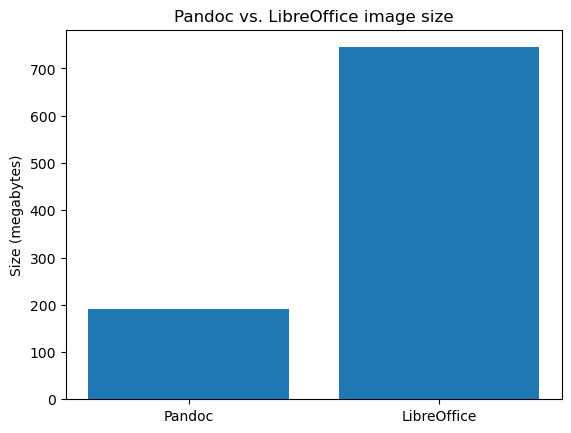

In [8]:
# Compare the compressed size of each Docker image

fig, ax = plt.subplots()

ax.set_title("Pandoc vs. LibreOffice image size")
ax.set_ylabel("Size (megabytes)")
ax.bar(["Pandoc", "LibreOffice"], [191.19, 744.85])

# Sources: https://hub.docker.com/r/pandoc/latex/tags, https://hub.docker.com/r/instructure/libreoffice

plt.show()